In [1]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("justinpakzad/vestiaire-fashion-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, 'vestiaire.csv'), low_memory=False)

Path to dataset files: /Users/banutiryaki/.cache/kagglehub/datasets/justinpakzad/vestiaire-fashion-dataset/versions/2


In [2]:
df['item_type'] = df['product_type'].str.strip().str.split().str[-1].str.lower()

In [3]:
type_counts = df['item_type'].value_counts()
df = df[df['item_type'].isin(type_counts[type_counts > 1].index)]

In [4]:
brand_counts = df['brand_name'].value_counts()

top_n = [50, 100, 200, 500, 1000, 2000]
for n in top_n:
    covered = brand_counts.iloc[:n].sum()
    total = len(df)
    percent = round(covered / total * 100, 2)
    print(f"Top {n} brands cover {covered} products ({percent}%)")


Top 50 brands cover 413161 products (45.88%)
Top 100 brands cover 528278 products (58.66%)
Top 200 brands cover 629866 products (69.95%)
Top 500 brands cover 743651 products (82.58%)
Top 1000 brands cover 809934 products (89.94%)
Top 2000 brands cover 857565 products (95.23%)


In [5]:
top_1000_brands = df['brand_name'].value_counts().nlargest(1000).index
df['brand_trimmed'] = df['brand_name'].where(df['brand_name'].isin(top_1000_brands), 'other')

In [6]:
condition_map = {
    'Fair condition': 0,
    'Good condition': 1,
    'Very good condition': 2,
    'Never worn': 3,
    'Never worn, with tag': 4
}
df['product_condition_mapped'] = df['product_condition'].map(condition_map)


In [7]:
gender_map = {
    'Women': 0,
    'Men': 1
}
df['gender_encoded'] = df['product_gender_target'].map(gender_map)


In [8]:
df = df[df['price_usd'] != df['price_usd'].max()]

In [9]:
from sklearn.preprocessing import LabelEncoder

df_model = df.copy()
brand_encoder = LabelEncoder()
df_model['brand_encoded'] = brand_encoder.fit_transform(df_model['brand_trimmed'])

df_model = pd.get_dummies(df_model, columns=['item_type'], prefix='item')


feature_cols = (
    [col for col in df_model.columns if col.startswith('item_')] + 
    ['brand_encoded', 'product_condition_mapped', 'gender_encoded']
)

X = df_model[feature_cols]
y = df_model['price_usd']



In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [14]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42
}

lgb_model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 720405, number of used features: 92
[LightGBM] [Info] Start training from score 387.177770


LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression',
              random_state=42)

In [15]:
y_pred_lgb = lgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred_lgb)
mae = mean_absolute_error(y_test, y_pred_lgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM R² Score: {r2:.4f}")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")


LightGBM R² Score: 0.3714
MAE: $226.97
RMSE: $1135.04


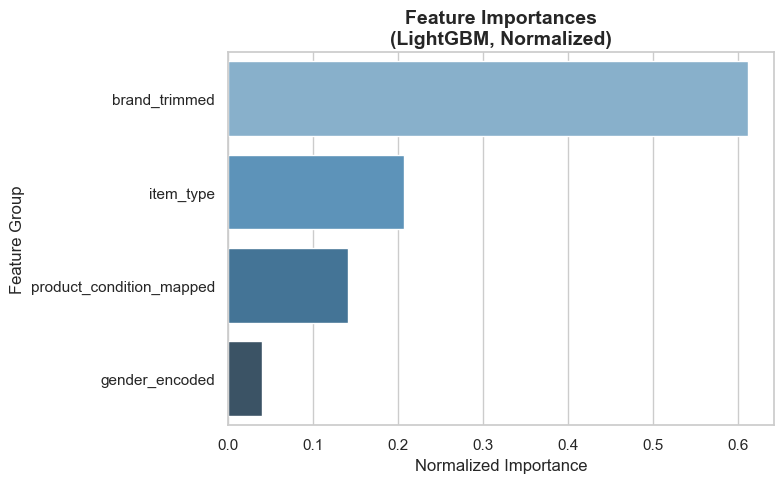

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get raw feature importances from LightGBM
importances = lgb_model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Normalize the importances so they sum to 1 (like in Random Forest)
feat_imp_df['normalized_importance'] = feat_imp_df['importance'] / feat_imp_df['importance'].sum()

# Group item_type features into one category
def categorize_feature(name):
    if name.startswith("item_"):
        return "item_type"
    elif name == "brand_encoded":
        return "brand_trimmed"
    else:
        return name

feat_imp_df['category'] = feat_imp_df['feature'].apply(categorize_feature)

# Group by feature category
grouped_normalized = feat_imp_df.groupby('category')['normalized_importance'].sum().sort_values(ascending=False)

# Plot grouped normalized importances
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

sns.barplot(
    x=grouped_normalized.values,
    y=grouped_normalized.index,
    palette="Blues_d"
)

plt.xlabel("Normalized Importance", fontsize=12)
plt.ylabel("Feature Group", fontsize=12)
plt.title("Feature Importances\n(LightGBM, Normalized)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


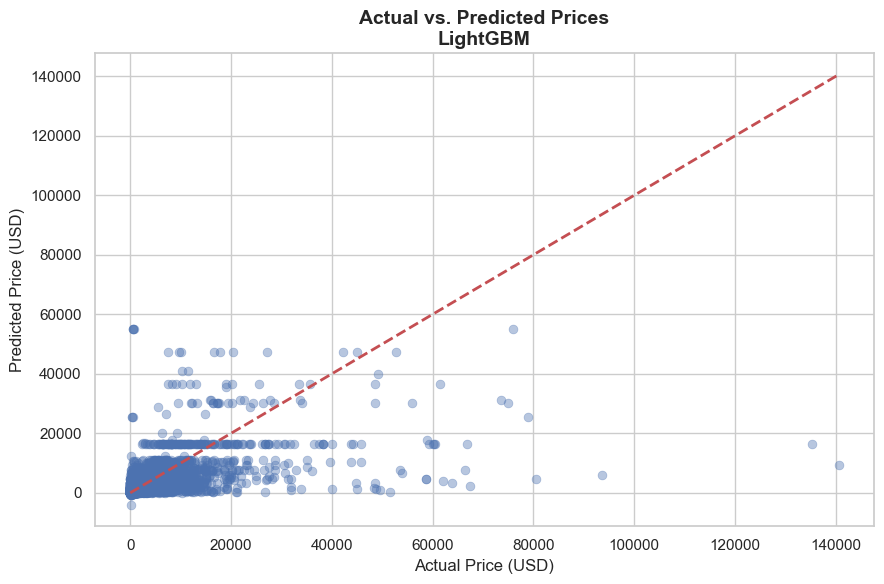

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 6))
sns.set(style="whitegrid")

# Scatter plot with color intensity based on error magnitude
sns.scatterplot(
    x=y_test,
    y=y_pred_lgb,
    alpha=0.4,
    edgecolor=None,
    s=40
)

# Add 45-degree reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Axis labels and title
plt.xlabel("Actual Price (USD)", fontsize=12)
plt.ylabel("Predicted Price (USD)", fontsize=12)
plt.title("Actual vs. Predicted Prices\nLightGBM", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


/Users/banutiryaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


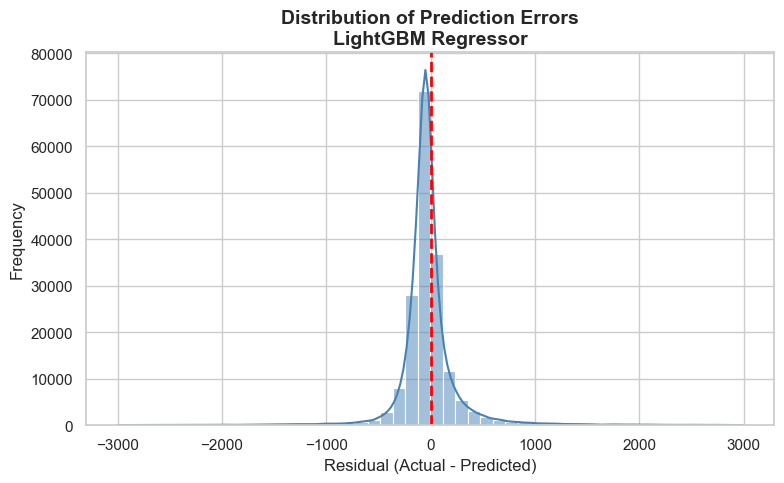

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals_lgb = y_test - y_pred_lgb

# Clip extreme values for better visualization
residuals_clipped = residuals_lgb[residuals_lgb.between(-3000, 3000)]

# Plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

sns.histplot(residuals_clipped, bins=50, kde=True, color='steelblue')

plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Residual (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Prediction Errors\nLightGBM Regressor", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
